In [1]:
import tensorflow as tf
from tqdm import tqdm
import pandas as pd
import numpy as np
import os
import shutil
import math
import cv2
import json
import random
import re
import sys
import datetime
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from PIL import Image
import glob
from keras.layers import *
from tensorflow.keras import Model, layers, initializers
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, f1_score, classification_report
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Efficient net, see: https://pypi.org/project/keras-efficientnets/
# if error "No Module named 'keras_applications" see: https://github.com/keras-team/keras-contrib/issues/283
from keras_efficientnets import EfficientNetB4


Data from Dog Emotions Prediction - 
https://www.kaggle.com/datasets/devzohaib/dog-emotions-prediction

Code from Dog Emotions Prediction TF EfficientNetB4+ResMLP - 
https://www.kaggle.com/code/jiaowoguanren/dog-emotions-prediction-tf-efficientnetb4-resmlp

In [2]:
root = './images/'


def read_split_data(root, plot_image=False):

    filepaths = []
    labels = []
    bad_images = []

    random.seed(0)
    assert os.path.exists(root), 'Root directory does not exist'

    classes = [cla for cla in os.listdir(root) 
        if os.path.isdir(os.path.join(root, cla))]
    classes.sort()

    class_indices = {k: v for v, k in enumerate(classes)}
    json_str = json.dumps({v: k for k, v in class_indices.items()}, indent=4)

    with open('classes_indices.json', 'w') as json_file:
        json_file.write(json_str)

    every_class_num = []
    supported = ['.jpg', '.png', '.jpeg', '.PNG', '.JPG', '.JPEG']

    for klass in classes:
        classpath = os.path.join(root, klass)
        images = [os.path.join(root, klass, i) for i in os.listdir(classpath) 
            if os.path.splitext(i)[-1] in supported]
        every_class_num.append(len(images))
        flist = sorted(os.listdir(classpath))
        desc = f'{klass:23s}'
        for f in tqdm(flist, ncols=110, desc=desc, unit='file', colour='blue'):
            fpath = os.path.join(classpath, f)
            fl = f.lower()
            index = fl.rfind('.')
            ext = fl[index:]
            if ext in supported:
                try:
                    img = cv2.imread(fpath)
                    shape = img.shape
                    filepaths.append(fpath)
                    labels.append(klass)
                except:
                    bad_images.append(fpath)
                    print('defective image file: ', fpath)
            else:
                bad_images.append(fpath)
    Fseries = pd.Series(filepaths, name='filepaths')
    Lseries = pd.Series(labels, name='labels')
    df = pd.concat([Fseries, Lseries], axis=1)

    train_df, test_df = train_test_split(
        df, train_size=.8, shuffle=True, random_state=123, stratify=df['labels'])

    train_image_path = train_df['filepaths'].tolist()
    test_image_path = test_df['filepaths'].tolist()

    train_image_label = [class_indices[i] for i in train_df['labels'].tolist()]
    test_image_label = [class_indices[i] for i in test_df['labels'].tolist()]

    print('{} images were found in the dataset.\n{} for training, {} for testing'.format(
        sum(every_class_num), len(train_image_path), len(test_image_path)
    ))
    sample_df = train_df.sample(n=50, replace=False)
    ht, wt, count = 0, 0, 0
    for i in range(len(sample_df)):
        fp = sample_df['filepaths'].iloc[i]
        try:
            img = cv2.imread(fp)
            h = img.shape[0]
            w = img.shape[1]
            wt += w
            ht += h
            count += 1
        except:
            pass

    have = int(ht / count)
    wave = int(wt / count)
    aspect_ratio = have / wave
    print('number of classes in processed dataset= ',
          len(train_df['labels'].unique()))
    counts = list(train_df['labels'].value_counts())
    print('the maximum files in any class in train_df is ', max(counts),
          '  the minimum files in any class in train_df is ', min(counts))
    print('train_df length: ', len(train_df),
          '  test_df length: ', len(test_df))
    print('average image height= ', have, '  average image width= ',
          wave, ' aspect ratio h/w= ', aspect_ratio)

    if plot_image:
        plt.bar(range(len(classes)), every_class_num, align='center')
        plt.xticks(range(len(classes)), classes)

        for i, v in enumerate(every_class_num):
            plt.text(x=i, y=v+5, s=str(v), ha='center')

        plt.xlabel('image class')
        plt.ylabel('number of images')

        plt.title('class distribution')
        plt.show()

    return train_image_path, train_image_label, test_image_path, test_image_label, class_indices


sad                    : 100%|█████████████████████████████████████████| 4532/4532 [00:05<00:00, 832.45file/s]


15921 images were found in the dataset.
12736 for training, 3185 for testing
number of classes in processed dataset=  4
the maximum files in any class in train_df is  3827   the minimum files in any class in train_df is  1805
train_df length:  12736   test_df length:  3185
average image height=  384   average image width=  384  aspect ratio h/w=  1.0


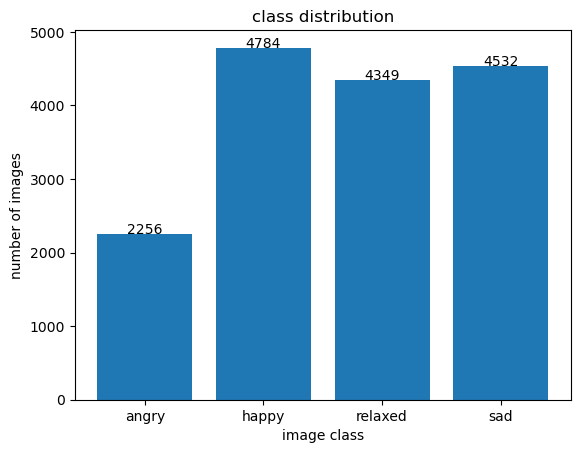

In [3]:
train_image_path, train_image_label, test_image_path, test_image_label, class_indices = read_split_data(
    root, plot_image=True)
AUTOTUNE = tf.data.experimental.AUTOTUNE


In [4]:
def generate_ds(img_height, img_width, batch_size):
    def process_train_info(img_path, label):
        image = tf.io.read_file(img_path)
        image = tf.image.decode_jpeg(image, channels=3)
        image = tf.image.convert_image_dtype(image, tf.float32)
        image = tf.image.resize_with_crop_or_pad(image, img_height, img_width)
        image = tf.image.random_flip_left_right(image)
        image = (image - 0.5) / 0.5

        return image, label

    def process_val_info(img_path, label):
        image = tf.io.read_file(img_path)
        image = tf.image.decode_jpeg(image, channels=3)
        image = tf.image.convert_image_dtype(image, tf.float32)
        image = tf.image.resize_with_crop_or_pad(image, img_height, img_width)
        image = (image - 0.5) / 0.5

        return image, label

    def configure_for_performance(ds, shuffle_size, shuffle=False):
        ds = ds.cache()
        if shuffle:
            ds = ds.shuffle(buffer_size=shuffle_size)
        ds = ds.batch(batch_size)
        ds = ds.prefetch(buffer_size=AUTOTUNE)

        return ds

    train_ds = tf.data.Dataset.from_tensor_slices((tf.constant(train_image_path),
                                                   tf.constant(train_image_label)))
    total_train = len(train_image_path)

    test_ds = tf.data.Dataset.from_tensor_slices((tf.constant(test_image_path),
                                                 tf.constant(test_image_label)))
    total_test = len(test_image_path)

    train_ds = train_ds.map(process_train_info, num_parallel_calls=AUTOTUNE)
    train_ds = configure_for_performance(train_ds, total_train, shuffle=True)

    test_ds = test_ds.map(process_val_info, num_parallel_calls=AUTOTUNE)
    test_ds = configure_for_performance(
        test_ds, shuffle_size=total_test, shuffle=False)

    return train_ds, test_ds


In [5]:
train_ds, test_ds = generate_ds(img_height=224, img_width=224, batch_size=32)

In [6]:
def GELU(x):
    res = 0.5 * x * (1 + tf.nn.tanh(math.sqrt(2 / math.pi)
                     * (x + 0.044715 * (x ** 3))))
    return res


class ResMLPBlock(tf.keras.layers.Layer):
    def __init__(self, units, residual_path):
        super(ResMLPBlock, self).__init__()
        self.residual_path = residual_path
        self.D1 = Dense(units, activation='relu')
        self.D2 = Dense(units, activation='relu')

        if self.residual_path:
            self.D3 = Dense(units)
            self.D4 = Dense(units)

    def call(self, inputs):
        residual = inputs

        x = self.D1(inputs)
        y = self.D2(x)

        if self.residual_path:
            residual = self.D3(inputs)
            residual = GELU(residual)
            residual = self.D4(residual)
            residual = GELU(residual)

        output = y + residual
        return output


In [7]:
class ResMLP(tf.keras.layers.Layer):
    def __init__(self, initial_filters, block_list, num_classes):
        super(ResMLP, self).__init__()
        self.initial_filters = initial_filters
        self.block_list = block_list

        self.D1 = Dense(self.initial_filters, activation='relu')
        self.B1 = BatchNormalization()

        self.blocks = tf.keras.models.Sequential()
        for block_id in range(len(block_list)):
            for layer_id in range(block_list[block_id]):
                if block_id != 0 and layer_id == 0:
                    block = ResMLPBlock(
                        units=self.initial_filters, residual_path=True)
                else:
                    block = ResMLPBlock(
                        units=self.initial_filters, residual_path=False)
                self.blocks.add(block)
            self.initial_filters *= 2

        self.D2 = Dense(num_classes, activation='softmax')

    def call(self, inputs):
        x = self.D1(inputs)
        x = self.B1(x)
        x = self.blocks(x)
        y = self.D2(x)
        return y


In [8]:
def make_model():
    base_model = EfficientNetB4(
        include_top=False, weights="imagenet", input_shape=(224, 224, 3), pooling='max') # was  tf.keras.applications.efficientnet.EfficientNetB4
    base_model.trainable = False
    x = base_model.output
    output = ResMLP(initial_filters=32, block_list=[2, 2, 2], num_classes=4)(x)
    model = tf.keras.models.Model(inputs=base_model.input, outputs=output)
    return model


In [9]:
model = make_model()


In [17]:
batch_size = 32
epochs = 10
initial_lr = 0.0001
weight_decay = 1e-5
best_val_acc = 0.0

model.build((1, 224, 224, 3))
# model.summary()

log_dir = "./logs/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
train_writer = tf.summary.create_file_writer(os.path.join(log_dir, "train"))
val_writer = tf.summary.create_file_writer(os.path.join(log_dir, "val"))

loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False)
optimizer = tf.keras.optimizers.Adam(learning_rate=initial_lr)

train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(
    name='train_accuracy')

test_loss = tf.keras.metrics.Mean(name='test_loss')
test_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(
    name='test_accuracy')


def scheduler(now_epoch):
    end_lr_rate = 0.01
    rate = ((1 + math.cos(now_epoch * math.pi / epochs)) / 2) * \
        (1 - end_lr_rate) + end_lr_rate  # cosine
    new_lr = rate * initial_lr

    with train_writer.as_default():
        tf.summary.scalar('learning rate', data=new_lr, step=epoch)

    return new_lr


@tf.function
def train_step(images, labels):
    with tf.GradientTape() as tape:
        predictions = model(images)
        ce_loss = loss_object(labels, predictions)

        matcher = re.compile('.*(bias|gamma|beta).*')
        l2loss = weight_decay * \
            tf.add_n([tf.nn.l2_loss(v)
                     for v in model.trainable_variables if not matcher.match(v.name)])

        loss = ce_loss + l2loss

    grads = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))

    train_loss(loss)
    train_accuracy(labels, predictions)


@tf.function
def test_step(images, labels):
    predictions = model(images)
    loss = loss_object(labels, predictions)

    test_loss(loss)
    test_accuracy(labels, predictions)


train_Acc, train_Loss, test_Acc, test_Loss = [], [], [], []
# Plotting
train_accuracy_plot, train_loss_plot, test_accuracy_plot, test_loss_plot = [], [], [], []
for epoch in range(epochs):
    train_loss.reset_states()
    train_accuracy.reset_states()
    test_loss.reset_states()
    test_accuracy.reset_states()

    train_bar = tqdm(train_ds, file=sys.stdout)
    for images, labels in train_bar:
        train_step(images, labels)
        train_Acc.append(train_accuracy.result().numpy())
        train_Loss.append(train_loss.result().numpy())
        optimizer.learning_rate = scheduler(epoch)
        train_bar.desc = "train epoch[{}/{}] loss:{:.3f}, acc:{:.3f}".format(epoch + 1,
                                                                             epochs,
                                                                             train_loss.result(),
                                                                             train_accuracy.result())

    test_bar = tqdm(test_ds, file=sys.stdout)
    for images, labels in test_bar:
        test_step(images, labels)
        test_Acc.append(test_accuracy.result().numpy())
        test_Loss.append(test_loss.result().numpy())
        test_bar.desc = "test epoch[{}/{}] loss:{:.3f}, acc:{:.3f}".format(epoch + 1,
                                                                           epochs,
                                                                           test_loss.result(),
                                                                           test_accuracy.result())

    with train_writer.as_default():
        tf.summary.scalar("loss", train_loss.result(), epoch)
        tf.summary.scalar("accuracy", train_accuracy.result(), epoch)

    with val_writer.as_default():
        tf.summary.scalar("loss", test_loss.result(), epoch)
        tf.summary.scalar("accuracy", test_accuracy.result(), epoch)

    # Plot vars
    train_accuracy_plot.append(train_accuracy.result())
    train_loss_plot.append(train_loss.result())
    test_accuracy_plot.append(test_accuracy.result())
    test_loss_plot.append(test_loss.result())

    # only save best weights
    if test_accuracy.result() > best_val_acc:
        best_val_acc = test_accuracy.result()
        save_name = "./save_weights/model.ckpt"
        model.save_weights(save_name, save_format="tf")


test epoch[10/10] loss:1.380, acc:0.418: 100%|██████████| 100/100 [00:18<00:00,  5.55it/s]


In [20]:
def save_results(path, train_acc, train_loss, test_acc, test_loss):
    '''Save the training and test loss, accuracy.'''

    cv_file = cv2.FileStorage(path, cv2.FILE_STORAGE_WRITE)
    cv_file.write('train_acc', train_acc)
    cv_file.write('train_loss', train_loss)
    cv_file.write('test_acc', test_acc)
    cv_file.write('test_loss', test_loss)

    # note you *release* you don't close() a FileStorage object
    cv_file.release()

def load_results(path):
    '''Loads training and test loss, accuracy.'''

    # FILE_STORAGE_READ
    cv_file = cv2.FileStorage(path, cv2.FILE_STORAGE_READ)

    # note we also have to specify the type to retrieve other wise we only get a
    # FileNode object back instead of a matrix
    train_acc = cv_file.getNode('train_acc').mat()
    train_loss = cv_file.getNode('train_loss').mat()
    test_acc = cv_file.getNode('test_acc').mat()
    test_loss = cv_file.getNode('test_loss').mat()

    cv_file.release()

    return  train_acc, train_loss, test_acc, test_loss

# Plot vars saved below
results_path = os.path.join(log_dir,"train_test_epoch_metrics.yml")
save_results(results_path, np.array(train_accuracy_plot), np.array(train_loss_plot), np.array(test_accuracy_plot), np.array(test_loss_plot))

In [24]:
# Load results from file if variable is no longer available
# verify results_path is availiable and correct before running
train_accuracy_plot, train_loss_plot, test_accuracy_plot, test_loss_plot = load_results(results_path)

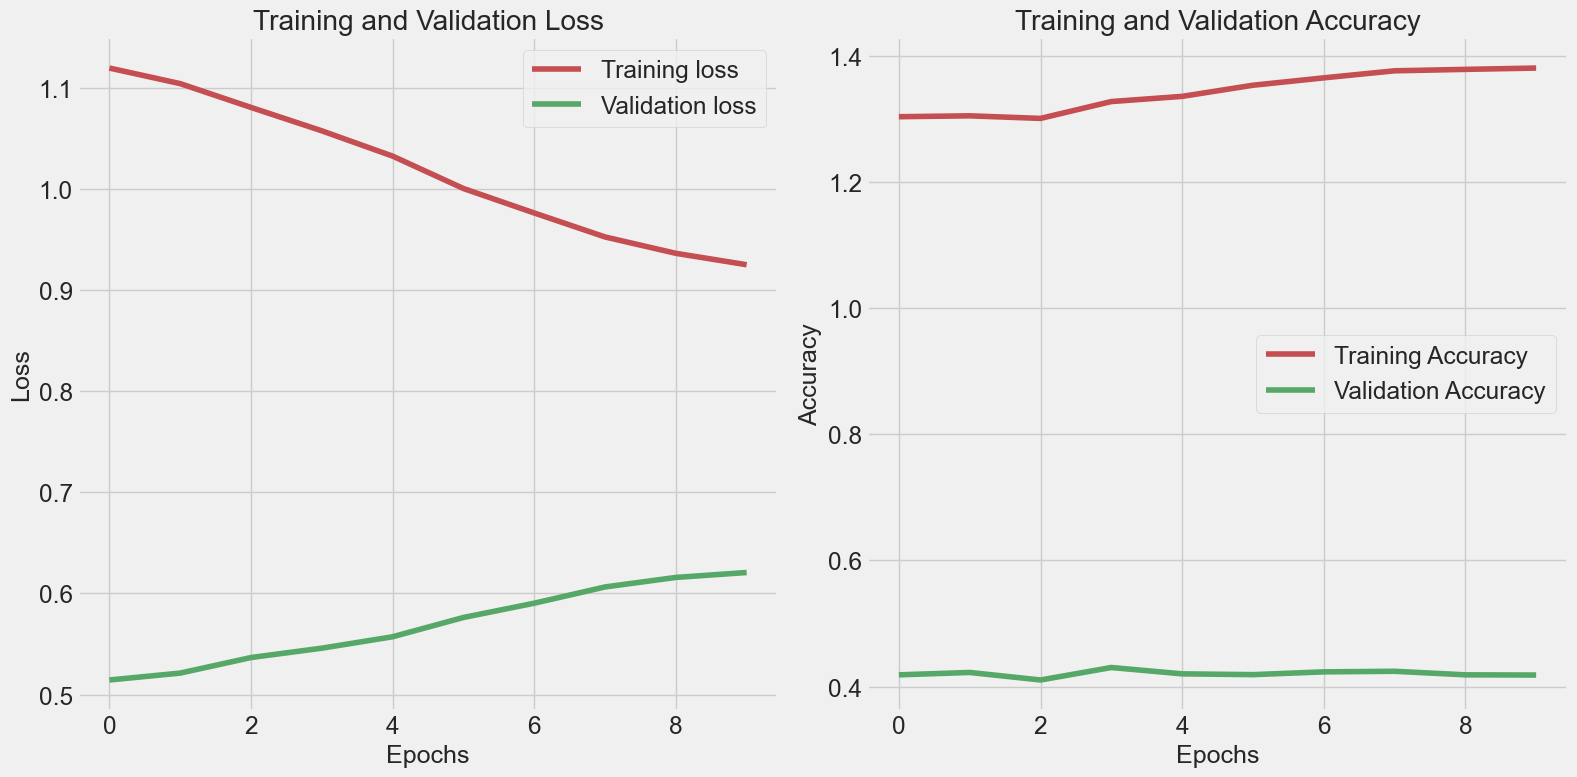

In [25]:
def plot_acc_loss(epochs):

    Epochs = [i for i in range(epochs)]

    plt.style.use('fivethirtyeight')
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 8))
    axes[0].plot(Epochs, train_loss_plot, 'r', label='Training loss')
    axes[0].plot(Epochs, train_accuracy_plot, 'g', label='Validation loss')
    axes[0].set_title('Training and Validation Loss')
    axes[0].set_xlabel('Epochs', fontsize=18)
    axes[0].set_ylabel('Loss', fontsize=18)
    axes[0].legend()

    axes[1].plot(Epochs, test_loss_plot, 'r', label='Training Accuracy')
    axes[1].plot(Epochs, test_accuracy_plot, 'g', label='Validation Accuracy')
    axes[1].set_title('Training and Validation Accuracy')
    axes[1].set_xlabel('Epochs', fontsize=18)
    axes[1].set_ylabel('Accuracy', fontsize=18)
    axes[1].legend()

    plt.tight_layout()
    plt.show()

    return Epochs


epochs = plot_acc_loss(epochs=10)


1/1 [==============================] - 2s 2s/step


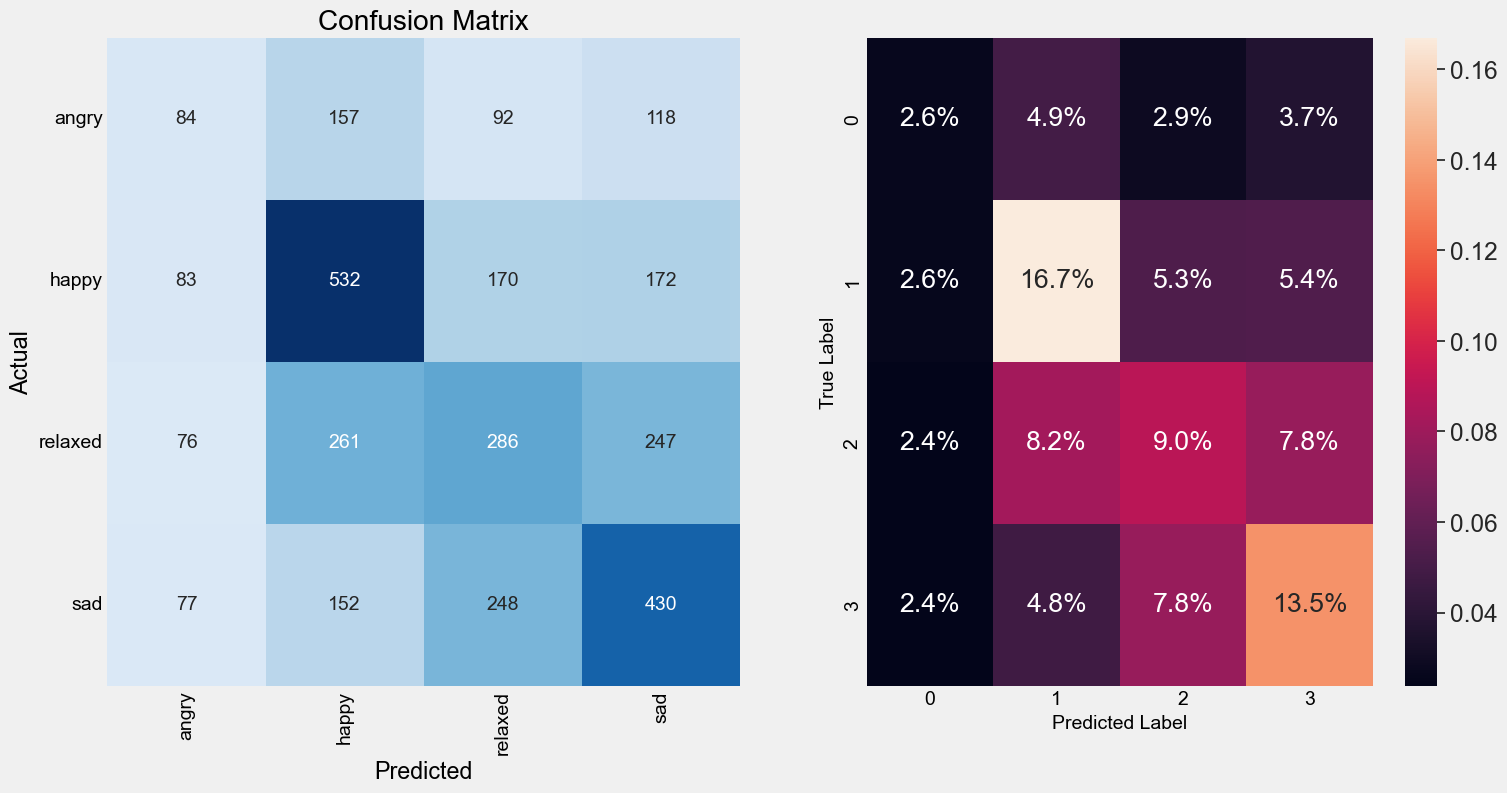

Classification Report:
----------------------
               precision    recall  f1-score   support

       angry     0.2625    0.1863    0.2179       451
       happy     0.4828    0.5559    0.5168       957
     relaxed     0.3593    0.3287    0.3433       870
         sad     0.4447    0.4741    0.4589       907

    accuracy                         0.4182      3185
   macro avg     0.3873    0.3862    0.3842      3185
weighted avg     0.4070    0.4182    0.4106      3185



In [23]:
def predictor(val_ds):
    y_pred, y_true = [], []
    classes = class_indices.keys()
    class_count = len(classes)
    for images, labels in val_ds:
        predictions = np.argmax(model.predict(images), axis=1)
        for i in range(len(predictions)):
            y_pred.append(predictions[i])
            y_true.append(labels.numpy()[i])
    y_pred = np.array(y_pred)
    y_true = np.array(y_true)
    f1score = f1_score(y_true, y_pred, average='weighted') * 100

    cm = confusion_matrix(y_true, y_pred)

    plt.figure(figsize=(16, 8))

    plt.subplot(1, 2, 1)
    sns.heatmap(cm, annot=True, vmin=0, fmt='g', cmap='Blues', cbar=False)
    plt.xticks(np.arange(class_count) + .5, classes, rotation=90)
    plt.yticks(np.arange(class_count) + .5, classes, rotation=0)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Confusion Matrix")

    plt.subplot(1, 2, 2)
    sns.set(font_scale=1.6)
    sns.heatmap(cm / np.sum(cm), annot=True, fmt='.1%')
    plt.xlabel('Predicted Label', fontsize=14)
    plt.xticks(fontsize=14)
    plt.ylabel('True Label', fontsize=14)
    plt.yticks(fontsize=14)
    plt.show()

    clr = classification_report(y_true, y_pred, target_names=classes, digits=4)
    print("Classification Report:\n----------------------\n", clr)

    return f1score


f1score = predictor(test_ds)


In [ ]:
from yellowbrick.model_selection import learning_curve
#https://www.scikit-yb.org/en/latest/api/model_selection/learning_curve.html

# do not split X and Y into X_Train, Y_train etc. this is done when learning_curve is called, so just use original X and Y
# cv = variable for the number of folds. Standard number is 3, 5, 10
# cv changed to 2 as each iteration needs training (~45min)

# TODO - reformat above data to X,y for function below
print(learning_curve(model, X, Y, cv=2, scoring='accuracy',n_jobs=-1))